In [1]:
import os
import random
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
CATEGORIES = ["bottle", "cable", "hazelnut"]

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    if not os.path.exists(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

samples = []
for cat in CATEGORIES:
    cat_path = os.path.join(DATASET_PATH, cat)

    # good images (label 0)
    good_dir = os.path.join(cat_path, "train", "good")
    for p in list_images(good_dir):
        samples.append((p, 0, cat, "good"))

    # defect images (label 1)
    test_dir = os.path.join(cat_path, "test")
    for defect_type in os.listdir(test_dir):
        sub = os.path.join(test_dir, defect_type)
        if defect_type == "good" or (not os.path.isdir(sub)):
            continue
        for p in list_images(sub):
            samples.append((p, 1, cat, defect_type))

random.seed(42)
random.shuffle(samples)

val_ratio = 0.2
val_size = int(len(samples) * val_ratio)
val_samples = samples[:val_size]
train_samples = samples[val_size:]

print("Train:", len(train_samples), " Val:", len(val_samples))
print("Train label counts:", dict(Counter([s[1] for s in train_samples])))
print("Val label counts:", dict(Counter([s[1] for s in val_samples])))


Train: 840  Val: 209
Train label counts: {0: 653, 1: 187}
Val label counts: {0: 171, 1: 38}


In [3]:
weights = ResNet18_Weights.DEFAULT

# Stronger data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Validation: no augmentation, just resize + normalize
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class MVtecGoodDefectDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, category, subtype = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long), category, subtype


In [4]:
BATCH_SIZE = 32

# Use augmented transform for training, clean transform for validation
train_ds = MVtecGoodDefectDataset(train_samples, transform=train_transform)
val_ds   = MVtecGoodDefectDataset(val_samples,   transform=val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print("Train batches:", len(train_loader), " Val batches:", len(val_loader))


Train batches: 27  Val batches: 7


In [5]:
model = resnet18(weights=weights)

# Change final layer to 2 classes
model.fc = nn.Linear(model.fc.in_features, 2)

# 1) Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# 2) Unfreeze only layer4 + fc
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

model = model.to(device)

print("Trainable parameters (should be only layer4 + fc):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("  ", name)


Trainable parameters (should be only layer4 + fc):
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   fc.weight
   fc.bias


In [6]:
model.load_state_dict(
    torch.load("outputs/resnet18_mvtec_good_vs_defect.pth", map_location=device)
)
model.eval()
print("Loaded trained weights")


Loaded trained weights


In [7]:
gradients = None
activations = None

def forward_hook(module, inp, out):
    global activations
    activations = out

def full_backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

target_layer = model.layer4[-1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(full_backward_hook)

print("Hooks registered")


Hooks registered


Sample: bottle broken_large | true = 1
Pred: 1 | probs [good, defect] = [3.1643424e-11 1.0000000e+00]


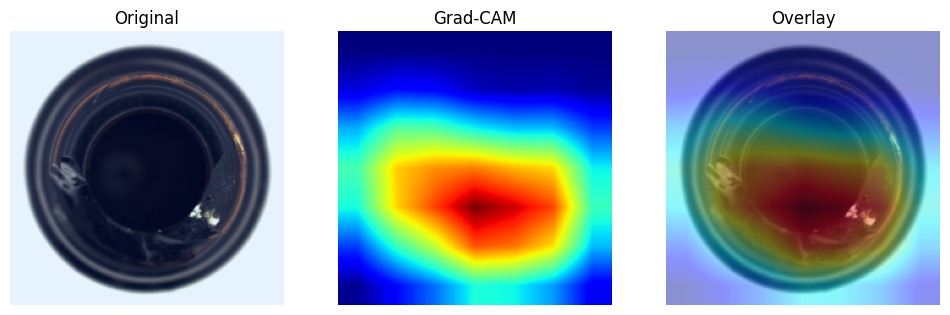

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# pick one defect sample
for i in range(len(val_ds)):
    img, label, cat, subtype = val_ds[i]
    if label.item() == 1:
        break

x = img.unsqueeze(0).to(device)

model.eval()
model.zero_grad()

logits = model(x)
pred = int(logits.argmax(dim=1).item())
probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()

print("Sample:", cat, subtype, "| true =", label.item())
print("Pred:", pred, "| probs [good, defect] =", probs)

score = logits[0, pred]
score.backward()

# Grad-CAM
pooled_grads = gradients.mean(dim=[0, 2, 3])
cam = torch.zeros(activations.shape[2:], device=device)

for j, w in enumerate(pooled_grads):
    cam += w * activations[0, j]

cam = torch.clamp(cam, min=0)
cam = cam / (cam.max() + 1e-8)
cam = cam.detach().cpu().numpy()

# upscale 7x7 -> 224x224
cam = cv2.resize(cam, (224, 224))

# display image
img_np = x[0].detach().cpu().permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.6 * img_np + 0.4 * heatmap
overlay = overlay / overlay.max()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.show()


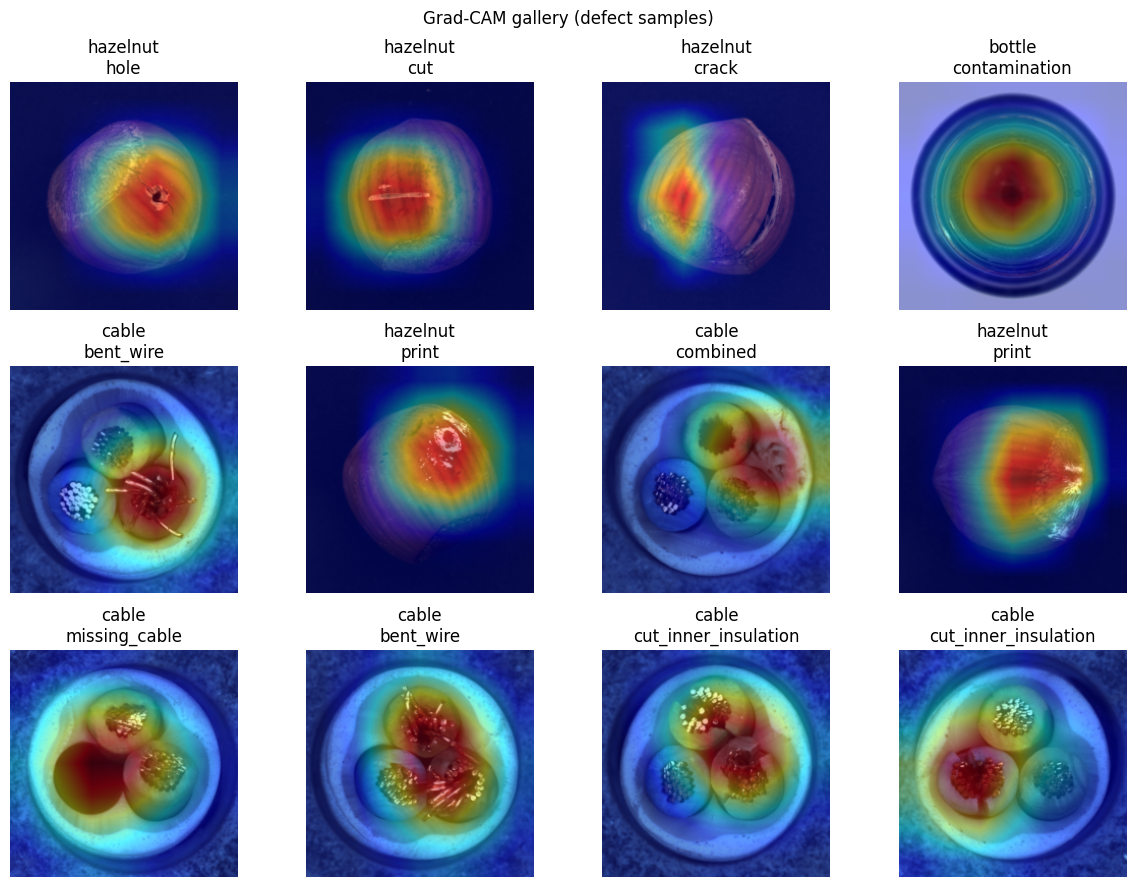

Saved: outputs/gradcam_gallery.png


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

os.makedirs("outputs", exist_ok=True)

def make_gradcam_overlay(img_tensor):
    # img_tensor: [3,224,224] already transformed
    x = img_tensor.unsqueeze(0).to(device)

    model.eval()
    model.zero_grad()
    logits = model(x)
    pred = int(logits.argmax(dim=1).item())

    score = logits[0, pred]
    score.backward()

    pooled_grads = gradients.mean(dim=[0, 2, 3])
    cam = torch.zeros(activations.shape[2:], device=device)

    for j, w in enumerate(pooled_grads):
        cam += w * activations[0, j]

    cam = torch.clamp(cam, min=0)
    cam = cam / (cam.max() + 1e-8)
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    img_np = x[0].detach().cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = 0.6 * img_np + 0.4 * heatmap
    overlay = overlay / overlay.max()
    return img_np, cam, overlay, pred

# pick 12 random defect samples from val_ds
defect_idxs = [i for i in range(len(val_ds)) if val_ds[i][1].item() == 1]
random.seed(7)
picked = random.sample(defect_idxs, k=min(12, len(defect_idxs)))

plt.figure(figsize=(12, 9))
for k, idx in enumerate(picked):
    img, label, cat, subtype = val_ds[idx]

    img_np, cam, overlay, pred = make_gradcam_overlay(img)

    plt.subplot(3, 4, k+1)
    plt.imshow(overlay)
    plt.title(f"{cat}\n{subtype}")
    plt.axis("off")

plt.suptitle("Grad-CAM gallery (defect samples)")
out_path = "outputs/gradcam_gallery.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


In [10]:
import os
print("Current working directory:", os.getcwd())
print("Outputs folder absolute path:", os.path.abspath("outputs"))
print("Files inside outputs:", os.listdir("outputs") if os.path.exists("outputs") else "outputs folder does not exist")


Current working directory: C:\Users\parth\OneDrive\Desktop\mvtec_defect_detection\notebooks
Outputs folder absolute path: C:\Users\parth\OneDrive\Desktop\mvtec_defect_detection\notebooks\outputs
Files inside outputs: ['gradcam_gallery.png', 'misclassified', 'resnet18_mvtec_good_vs_defect.pth']


In [11]:
import os
os.startfile(os.path.abspath("outputs"))


## Training & evaluation section (fine-tuning, run to retrain)


In [12]:
train_counts = Counter([s[1] for s in train_samples])
num_good = train_counts[0]
num_def  = train_counts[1]

w_good = 1.0
w_def  = num_good / num_def

class_weights = torch.tensor([w_good, w_def], dtype=torch.float32).to(device)
print("Class weights [good, defect]:", class_weights.tolist())

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Only optimize parameters that are actually trainable (layer4 + fc)
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainable_params,
    lr=3e-5,          # lower LR for fine-tuning
    weight_decay=1e-4
)

print("Number of trainable parameter tensors:", len(trainable_params))


Class weights [good, defect]: [1.0, 3.491978645324707]
Number of trainable parameter tensors: 17


In [13]:
from sklearn.metrics import accuracy_score

def run_one_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []

    for imgs, labels, _, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = criterion(logits, labels)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc

EPOCHS = 8
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_one_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_one_epoch(model, val_loader, train=False)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")


Epoch 01 | train loss 0.1691 acc 0.949 | val loss 0.3720 acc 0.952
Epoch 02 | train loss 0.1507 acc 0.956 | val loss 0.2685 acc 0.952
Epoch 03 | train loss 0.0909 acc 0.974 | val loss 0.2683 acc 0.952
Epoch 04 | train loss 0.0866 acc 0.975 | val loss 0.1889 acc 0.971
Epoch 05 | train loss 0.0792 acc 0.976 | val loss 0.1979 acc 0.967
Epoch 06 | train loss 0.1101 acc 0.963 | val loss 0.2052 acc 0.962
Epoch 07 | train loss 0.0826 acc 0.973 | val loss 0.2077 acc 0.962
Epoch 08 | train loss 0.0557 acc 0.982 | val loss 0.2054 acc 0.971


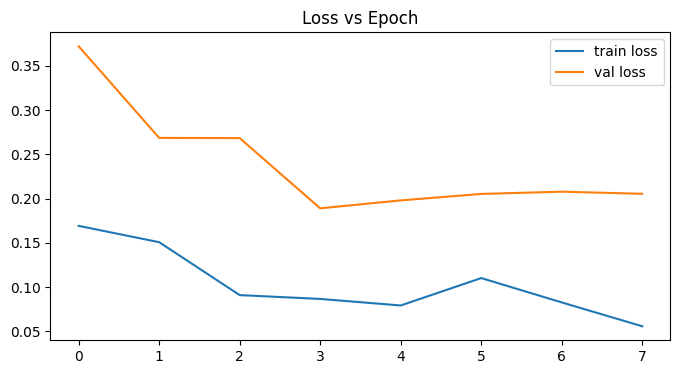

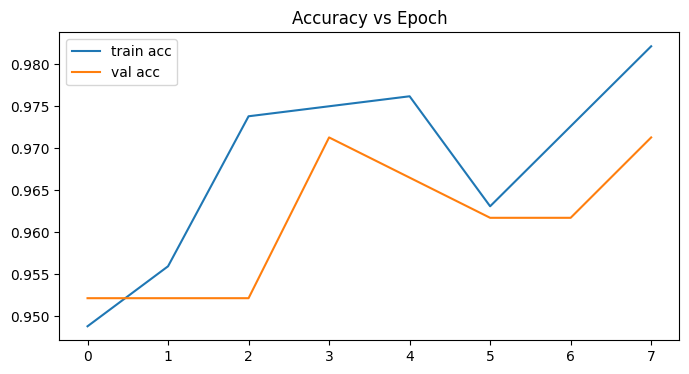

In [14]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()


In [15]:
os.makedirs("outputs", exist_ok=True)
checkpoint_path = "outputs/resnet18_mvtec_good_vs_defect_ft_layer4.pth"
torch.save(model.state_dict(), checkpoint_path)
print("Saved fine-tuned model to:", checkpoint_path)


Saved fine-tuned model to: outputs/resnet18_mvtec_good_vs_defect_ft_layer4.pth


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels, _, _ in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["good", "defect"],
    digits=4
))


Confusion Matrix:
[[171   0]
 [  6  32]]

Classification Report:
              precision    recall  f1-score   support

        good     0.9661    1.0000    0.9828       171
      defect     1.0000    0.8421    0.9143        38

    accuracy                         0.9713       209
   macro avg     0.9831    0.9211    0.9485       209
weighted avg     0.9723    0.9713    0.9703       209

